# 03 - Aprofundamento em Exploração e Alisamento Exponencial
- Métodos de Exploração:
    - Interactive Graphs: hvPlot
    - Decomposição de Séries
    - Teste de Estacionariedade
- Alisamento Exponencial Duplo e Triplo

### Preparação


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.datasets import co2, get_rdataset
import hvplot.pandas
import hvplot as hv
file = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True)
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
import warnings
warnings.filterwarnings('ignore')
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)
airp_df.reset_index().rename(columns={'value':'passengers', 'index':'date'}).to_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/air_passenger.csv', index=False)
plt.rcParams["figure.figsize"] = [12, 5]

# Visualização de Séries Temporais
Já aprendemos como  usar o plot do pandas:

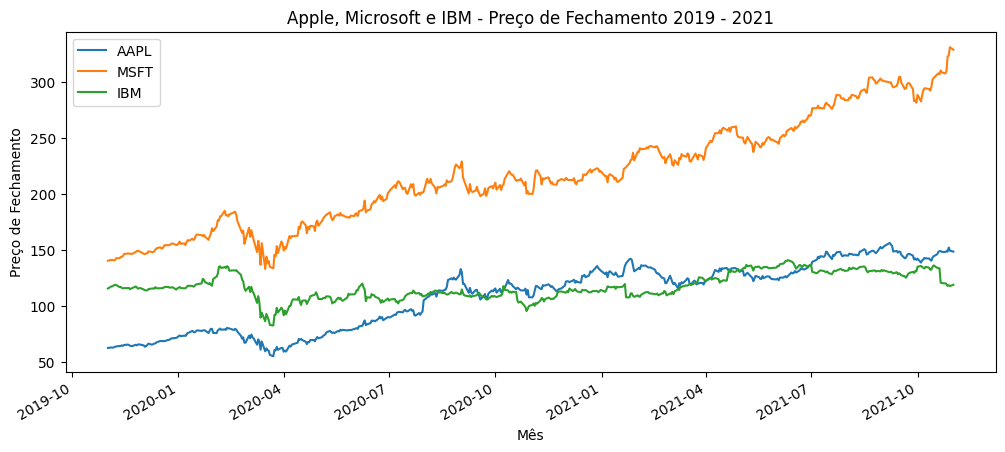

In [2]:
start_date = '2019'
end_date = '2021'
plot = closing_price.plot(title=f'Apple, Microsoft e IBM - Preço de Fechamento {start_date} - {end_date}',ylabel= 'Preço de Fechamento', xlabel='Mês')

Vou normalizar os dados dividindo os valores pelo primeiro valor de cada série. Vou também trocar o style:

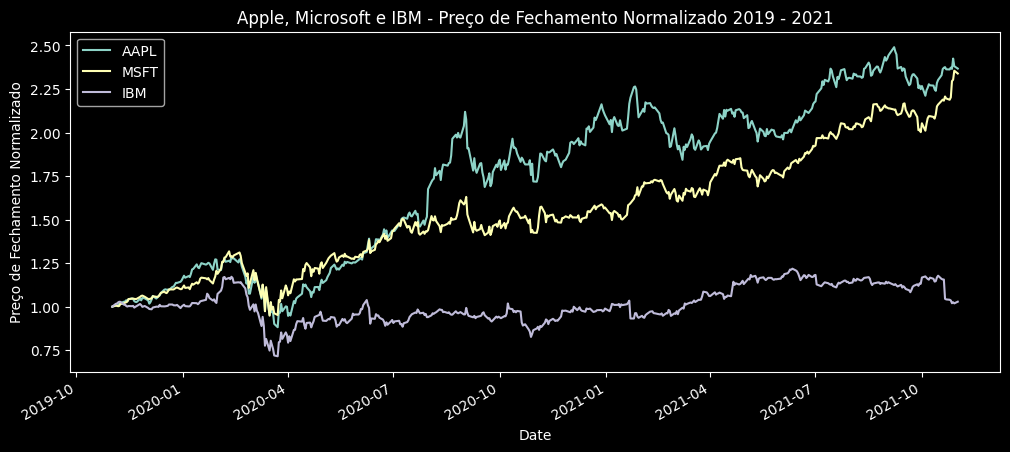

In [3]:
plt.style.use("dark_background")
closing_price_n = closing_price.div(closing_price.iloc[0])
plot = closing_price_n.plot(title=f'Apple, Microsoft e IBM - Preço de Fechamento Normalizado {start_date} - {end_date}',ylabel= 'Preço de Fechamento Normalizado')

Em séries temporais, o hvplot possibilita vermos a série de uma forma interativa:

In [4]:
closing_price_n.hvplot(title=f'Apple, Microsoft e IBM - Preço de Fechamento Normalizado {start_date} - {end_date}')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

O hvplot possui opções bem interessantes para visualizarmos as séries:

In [5]:
closing_price.hvplot(width=300, subplots=True)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

### Gráficos de sazonalidade

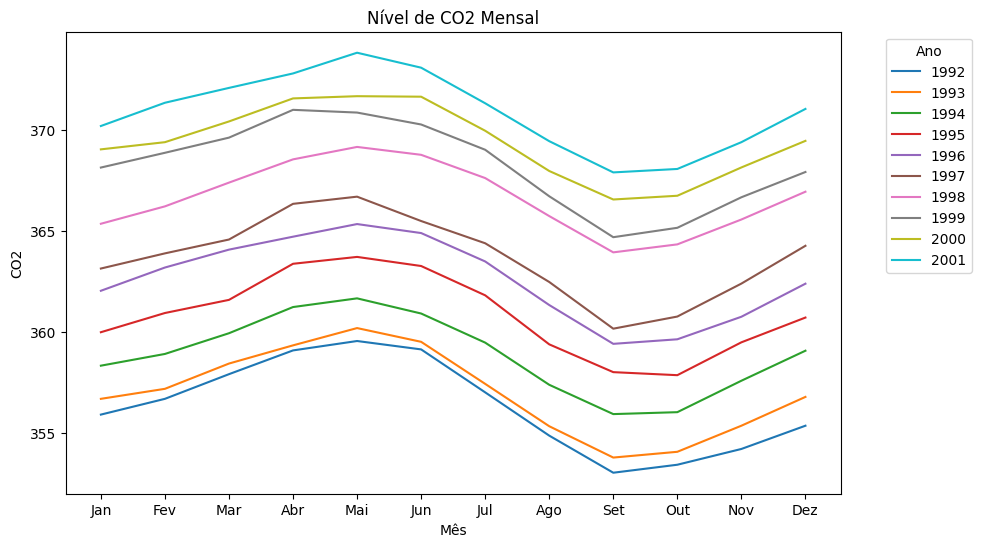

In [6]:
co2_month = co2_df.resample('MS').mean()
co2_month = co2_month[co2_month.index.year > 1991]
co2_month['Year'] = co2_month.index.year
co2_month['Month'] = co2_month.index.month
co2_month = co2_month.reset_index()
plt.style.use("default")
plt.figure(figsize=(10, 6))
sns.lineplot(data=co2_month, x='Month', y='co2', hue='Year', palette='tab10')
plt.xlabel('Mês')
plt.ylabel('CO2')
plt.xticks(ticks=co2_month['Month'].unique(), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.title('Nível de CO2 Mensal')
plt.legend(title='Ano', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Tem quem prefira visualizar os meses em um círculo:

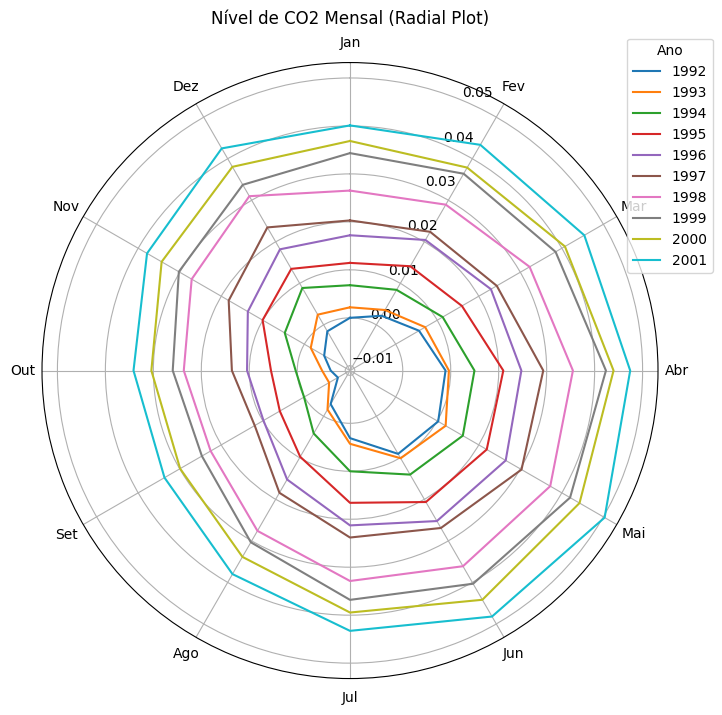

In [7]:
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)
co2_month['Month_rad'] = (co2_month['Month']-1) * (2 * np.pi / 12)
co2_month['co2_normalizado'] = (co2_month['co2']/co2_month['co2'][0])-1
years = co2_month['Year'].unique()
palette = sns.color_palette("tab10", len(years))
for i, year in enumerate(years):
    data = co2_month[co2_month['Year'] == year]
    data = pd.concat([data, data.iloc[[0]]])
    ax.plot(data['Month_rad'], data['co2_normalizado'], label=str(year), color=palette[i])

ax.set_theta_direction(-1) 
ax.set_theta_offset(np.pi / 2.0)  
ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.set_title('Nível de CO2 Mensal (Radial Plot)', va='bottom')
plt.legend(title='Ano', bbox_to_anchor=(1.1, 1.05))
plt.show()

### Decomposição de uma série:
Métodos:

- Hodrick-Prescott: Extrai a Tendência dos dados 
    - hp_filter
- Seasonal-Trend LOESS (Locally Estimated Sacatterplot Smoothing)
    - seasonal_decompose (Aditivo e Multiplicativo)
    - STL (Opção robusta porém assume relacionamento aditivo)
- Gráficos de sazonalidade.

### seasonal_decompose (Aditivo)

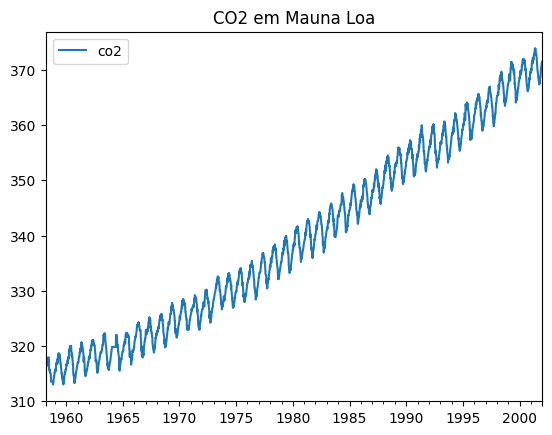

In [8]:
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
plt.style.use('default')
plpt = co2_df.plot(title='CO2 em Mauna Loa')

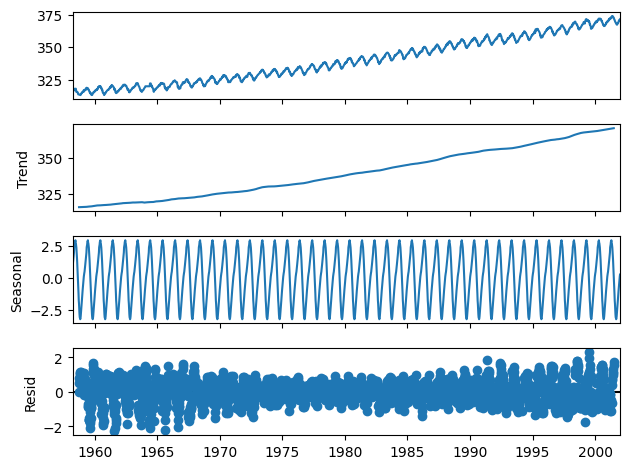

In [9]:
co2_decomposed = seasonal_decompose(co2_df,model='additive')
plot = co2_decomposed.plot()

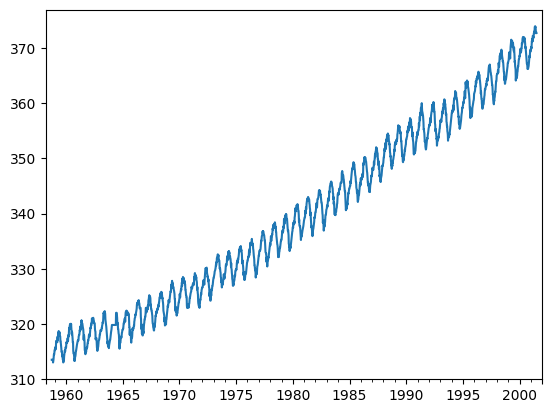

In [10]:
plot = (co2_decomposed.trend + 
     co2_decomposed.seasonal + 
     co2_decomposed.resid).plot()

### seasonal_decompose (Multiplicativo)

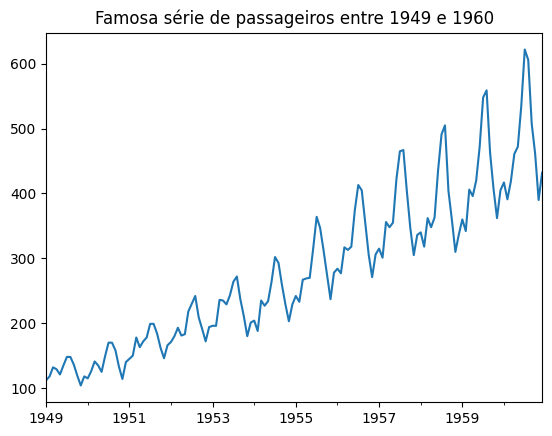

In [11]:
plot = airp_df['value'].plot(title='Famosa série de passageiros entre 1949 e 1960')

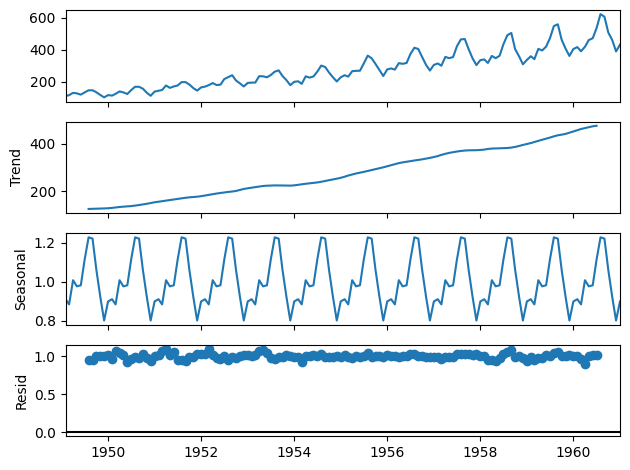

In [12]:
air_decomposed = seasonal_decompose(airp_df,model='multiplicative')
plot = air_decomposed.plot()

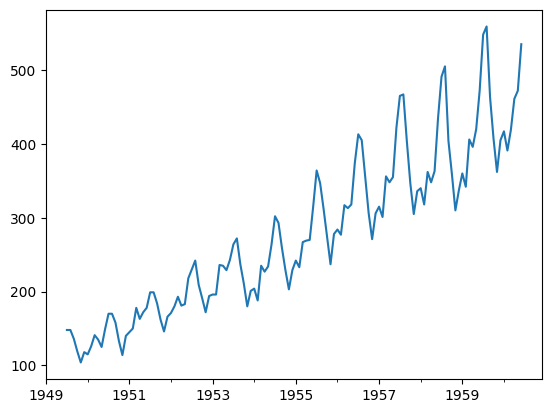

In [13]:
plot = (air_decomposed.trend * 
     air_decomposed.seasonal * 
     air_decomposed.resid).plot()

### STL (Opção aditiva apenas mas com robust=True)

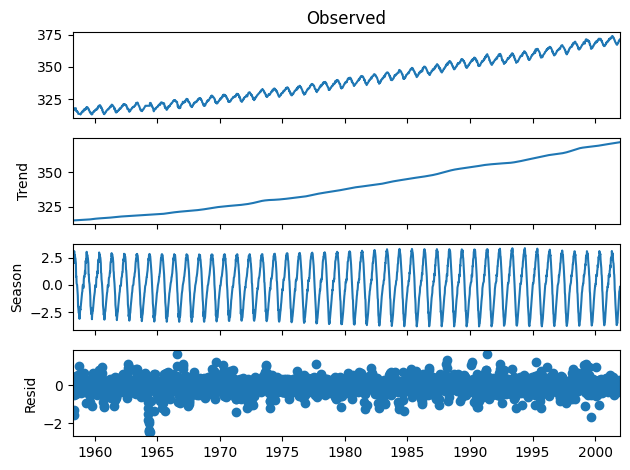

In [14]:
co2_stl = STL(
    co2_df, 
    seasonal=13, 
    robust=True).fit()
plot = co2_stl.plot()

### Hodrick - Prescott Filter

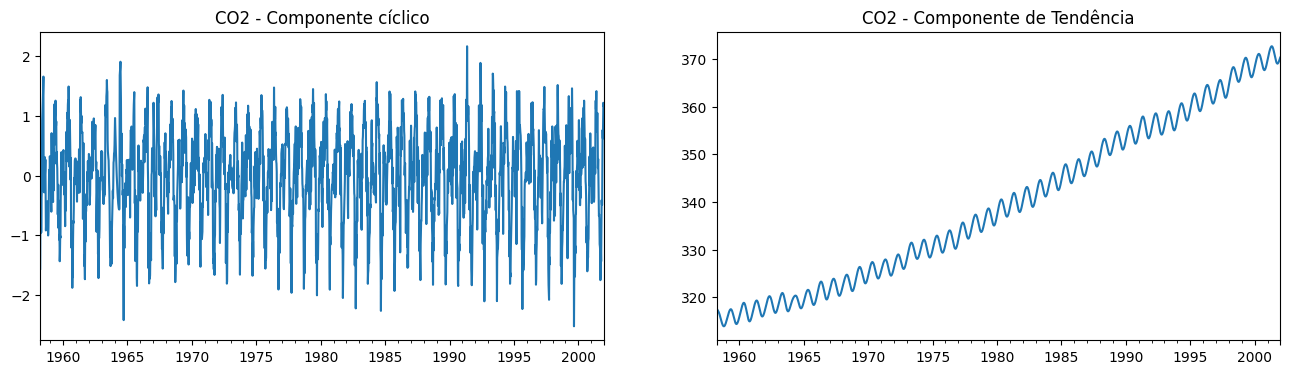

In [15]:
from statsmodels.tsa.filters.hp_filter import hpfilter
co2_cyclic, co2_trend = hpfilter(co2_df)
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 - Componente cíclico')
co2_trend.plot(ax=ax[1], title='CO2 - Componente de Tendência')
plt.show()

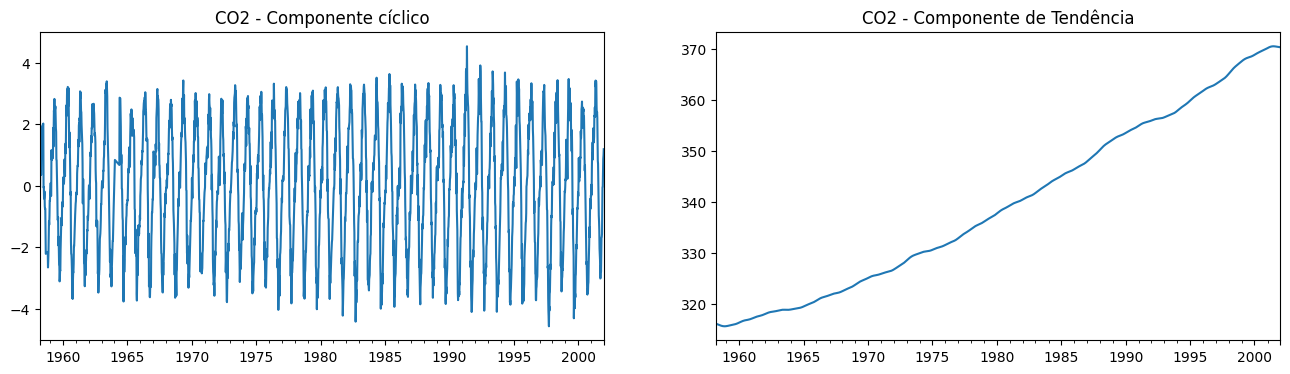

In [16]:
lamb = 270400
co2_cyclic, co2_trend = hpfilter(co2_df, lamb=lamb)
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 - Componente cíclico')
co2_trend.plot(ax=ax[1], title='CO2 - Componente de Tendência')
plt.show()

### Testeando a Estacionariedade


In [19]:
def print_results(output, test='adf', alpha=0.05):
    
    test_score = output[0]
    pval = output[1]
    
    decision = 'Não Estacionário'
    if test == 'adf':
        critical = output[4]
        if pval < alpha:
            decision = 'Estacionário'
    elif test=='kpss':
        critical = output[3]
        if pval >= alpha:
            decision = 'Estacionário'
            
    output_dict = {
    'Estatística do Teste': test_score,
    'p-valor': pval,
    'Decisão': decision
    }  
    return pd.Series(output_dict, name=test)

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss
adf_output = adfuller(co2_df)
kpss_output = kpss(co2_df)
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_4714/2196641140.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_output = kpss(co2_df)


,adf,kpss
Estatística do Teste,0.046051,7.649196
p-valor,0.962179,0.01
Decisão,Não Estacionário,Não Estacionário
